# Imports

In [1]:
# Python standard library modules.
from copy import deepcopy

# import importlib as imp
import matplotlib.pyplot as plt
import numpy as np

# Modules from the `telomeres` package.
from telomeres.model.plot import plot_laws
import telomeres.auxiliary.figures_properties as fp
import telomeres.dataset.plot as pd
import telomeres.lineage.plot as pl
import telomeres.lineage.simulation as sim
import telomeres.model.parameters as par
from telomeres.dataset.extract_processed_dataset import extract_postreat_lineages

# imp.reload(sim)

# Simulation and Plot

## 1. Model parameters

The default *model parameters* are defined by `telomeres.model.parameters.PAR_DEFAULT_LIN`.
They are not meant to be redefined except to test their sensitivity.

In [2]:
# Import default parameters.
PARAMETERS = deepcopy(
    par.PAR_DEFAULT_LIN
)  # Deepcopy ensures that any accidental modification of `PARAMETERS` do not affect `par.PAR_DEFAULT_LIN`.
print(PARAMETERS)

{'is_htype_accounted': True, 'is_htype_seen': True, 'fit': [[0.0247947389, 0.440063202], [[0.186824276, 0.725200993, 27.0], [2.45423414e-06, 0.122028128, 0.0]], [0, 40, 58]], 'p_exit': {'accident': 0.0043, 'death': 0.58, 'repair': 0.65, 'sen_limit': inf}, 'finalCut': None}


### 1.1. Quick description

Here is a quick description of the model parameters. See `telomeres.model.parameters.py` or the article for more details.  
* **`PARAMETERS['is_htype_accounted']`: Modeling assumption for *type H* cells**  
    - `True` if non-terminally arrested (*type B*) cells can enter senescence (therefore becoming *type H*)  
    - `False` otherwise. In this case, *type B* cells must exit their sequence of non-terminal arrests to be allowed to enter senescence  

    In practice, `PARAMETERS['is_htype_accounted']` is always `True` and should thus be removed from the code (remnant of the first code version).  

* **`PARAMETERS['fit']`: Fitted parameters**  
    - **Laws for arrest onset** (plotted below):  
        + $p_{nta} (\ell) = \min(1, b e^{-a \ell})$, with $(a, b) = (a_{nta}, b_{nta}) =$ `PARAMETERS['fit'][0]`
        + $p_{sen_A} (\ell) = \min(1, b e^{-a \ell} + 1_{\ell \leq \ell_{min}})$, with $(a, b, \ell_{min}) = (a_{sen_A}, b_{sen_A}, \ell_{min_A}) = $ `PARAMETERS['fit'][1][0]`
        + $p_{sen_B} (\ell) = \min(1, b e^{-a \ell} + 1_{\ell \leq \ell_{min}})$, with $(a, b, \ell_{min}) =  (a_{sen_B}, b_{sen_B}, \ell_{min_B}) = $ `PARAMETERS['fit'][1][1]`.
     
        <br>
    
    - **Transformation of the initial distribution of telomere length** (see article):  
        + $(\ell_{trans}, \ell_0, \ell_1) = $ `PARAMETERS['fit'][2]`

        <br>
* **`PARAMETERS['p_exit']`: Parameters for the "exit" of a cycle**
    - `PARAMETERS['p_exit']['accident']`: Rate of accidental death $p_{accident}$  
    - `PARAMETERS['p_exit']['death']` $= p_{death}$   
    - `PARAMETERS['p_exit']['repair']` $= p_{repair}$

        <br>
* **`PARAMETERS['finalCut']`: Parameters for the "finalCut" experimental conditions.** This is set to `None` if no such conditions apply, i.e. when time and generation $0$ correspond to telomerase inactivation.

### 1.2. Graphical representation.

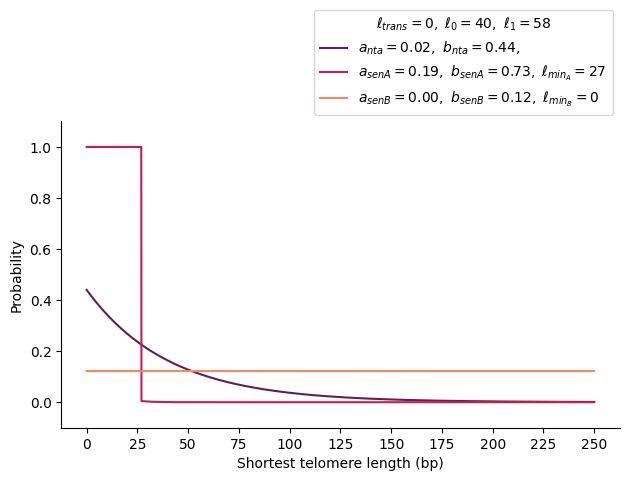

In [3]:
# Plot the laws for the onset of arrests.
# - Set `is_par_plot` to True for the parameters (rounded to a precision of 10e-2) to be plotted.
# - Adjust the spacing of the x-ticks using `tick_spacing`.
plot_laws(PARAMETERS["fit"], is_par_plot=True, tick_spacing=25)


 Distribution of telomere lengths: 
 ---------------------------------
Average initial length: 316 +/- 102
Median initial length: 301 +/- 103
Mode: 260 +/- 116
Support of distribution fonction: [73,1058]
int L_init(x) dx:  0.9999999999999998
Last values of <L_init_prob>:  [8.26296178e-09 5.99929752e-09 5.85456994e-09 5.71333709e-09]


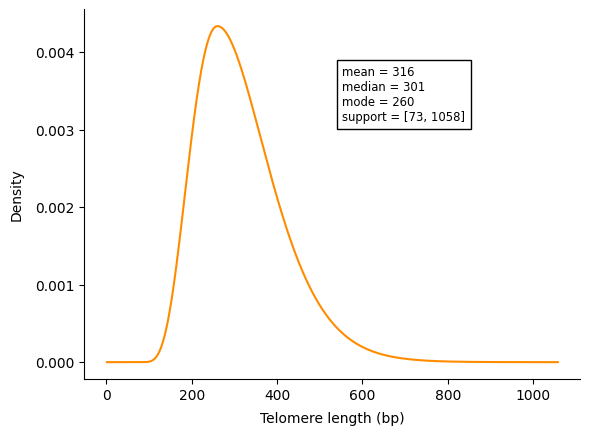

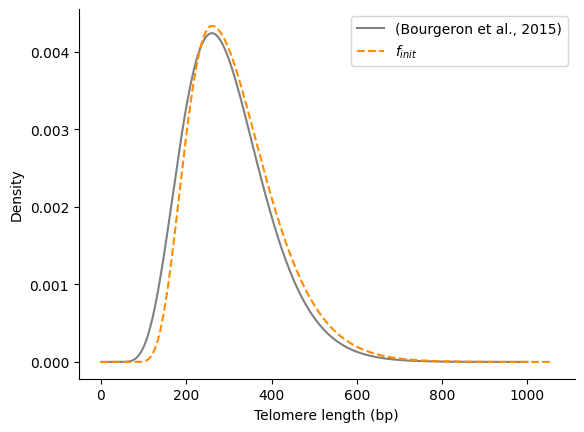

In [4]:
# Plot the distribution of initial telomere lengths.
# - Set `is_par_plot` to True for the parameters (rounded to a precision of 10e-2) to be plotted.
# - Adjust the spacing of the x-ticks using `tick_spacing`.
PAR_L_INIT = PARAMETERS["fit"][2]
LABELS = ["(Bourgeron et al., 2015)", r"$f_{init}$"]
FIG_DIR = None
pd.plot_ltelomere_init(FIG_DIR, par_l_init=PAR_L_INIT, labels=LABELS)

## 2. One lineage: simulation and output structure

In [2]:
# Simulation with default parameters.
# Note. A random Generator (RNG) (or a seed) must be provided for reproducibility.
#       Use a fixed seed to generate reproducible outputs; otherwise use None (default value), this will generate a new RNG each time.
SEED = None
rng = np.random.default_rng(SEED)
out = sim.simulate_lineage_evolution(PARAMETERS, rng)

NameError: name 'np' is not defined

The output list includes the following items, among others:

* **`out[0]`: Information on every cell in the lineage.** For each generation `i`
    - `out[0]['cycle'][i]`: Duration of the cell cycle (in minutes)
    - `out[0]['lavg'][i]`: The cell's average telomere length (in base pairs)
    - `out[0]['lmin'][i]`: The cell's shortest telomere length (in base pairs)

    <br>

* **`out[1]`: Generations at which special events have occurred**
    - `out[1]['nta']`: Onset of a sequence of non-terminal arrests
    - `out[1]['sen']`: Onset of senescence
    - `out[1]['death']`: Death

    <br>

* **`out[2]`: The *type* of the lineage** (`0`, `1`, or `NaN` for *type A*, *B*, or *H*).

* **`out[5]`: The number of arrests in each sequence of arrests**
    - `out[5]['nta'][i]`: The `i`th sequence of non-terminal arrests
    - `out[5]['sen']`: Senescence

* **`out[6]`: None if `PARAMETERS['finalCut']` is None, otherwise contain additional data relative to the finalCut setting**
    - `out[6]['len_af_cut']`: Telomere lengths right after the cut (None if no cut)

_Note._ `out[0]['cycle']` and `out[0]['lmin']` are lists, not arrays.<br>
      For better visualization of outputs below we convert them to numpy arrays before printing (`print({key: np.array(value) for key, value in out[0].items()}, out[1:])` rather than `print(out)`).


In [ ]:
print({key: np.array(value) for key, value in out[0].items()}, out[1:])

{'cycle': array([110,  80,  80,  60,  80,  80,  70,  70, 130, 100, 120, 130,  90,
        80, 130, 130,  90, 100, 100, 150,  90,  90, 190, 260, 120, 100,
       130, 450,  80, 150, 110, 160, 110, 160, 200, 360], dtype=int32), 'lavg': array([288.03125, 284.53125, 281.03125, 277.53125, 274.03125, 270.53125,
       267.03125, 263.53125, 260.03125, 256.53125, 253.03125, 249.53125,
       246.03125, 242.53125, 239.03125, 235.53125, 232.03125, 228.53125,
       225.03125, 221.53125, 218.03125, 214.53125, 211.03125, 207.53125,
       204.03125, 200.53125, 197.03125, 193.53125, 190.03125, 186.53125,
       183.03125, 179.53125, 176.03125, 172.53125, 169.03125, 165.53125]), 'lmin': array([140, 140, 140, 133, 133, 126, 119, 119, 112, 105, 105, 105, 105,
        98,  91,  84,  77,  70,  70,  70,  63,  56,  49,  42,  42,  35,
        28,  28,  21,  21,  21,  21,  14,  14,   7,   0])} ({'nta': [22, 27, 34], 'sen': 35, 'death': 35}, nan, None, False, {'nta': [2, 1], 'sen': 1}, None)


In [ ]:
# Simulation with extremely high accidental death rate.
# Remark. We expect shorter lineages in average.
PARAMETERS_TMP = deepcopy(PARAMETERS)
PARAMETERS_TMP["p_exit"]["accident"] *= 100  # p_accident 100 times bigger.

out = sim.simulate_lineage_evolution(PARAMETERS_TMP, rng)
print({key: np.array(value) for key, value in out[0].items()}, out[1:])

{'cycle': array([70], dtype=int32), 'lavg': array([323.5625]), 'lmin': array([154])} ({'nta': [], 'sen': nan, 'death': 0}, 0, None, True, {'nta': [], 'sen': nan}, None)



## 3. One set of lineages

### 3.1. Lineage characteristics

Simulating `LINEAGE_COUNT` lineages requires to specify their characteristics through a list of "characteristics" among, for example:
- **`'arrestedi'`**: Experiences at least `i` sequences of non-terminal arrests.
- **`'senescent'`**: Enters senescence.
- **`'atype'`, `'btype'`, `'htype'`**: Is of a specific *type* (*A*, *B* or *H*).
- **`'dead_accidentally'`**: Dies by accident.
  
The output have a structure similar to that of the one-lineage case, and provide as much information provided that:
- **`is_evo_returned`** is `True` (necessary for plotting cycle durations later); otherwise `out[0]` will be `None`
- **`is_lcycle_count_returned`** is `True`; otherwise `out[5]` will be `{'nta': None, 'sen': None}`.
- **`PARAMETERS['finalCut']`* is not `None`; otherwise `out[6]` will be `None`.


In [8]:
# New parameters required for simulation.
LINEAGE_COUNT = 50
CHARACTERISTICS = ["senescent"]

# Simulation.
# Remark. `is_evo_returned` must be set to `True` to later plot all cycle duration times (otherwise out[0] is None).
out = sim.simulate_lineages_evolution(
    LINEAGE_COUNT, CHARACTERISTICS, PARAMETERS, is_evo_returned=True
)

New subsimulation.


### 3.2. Cycle duration times

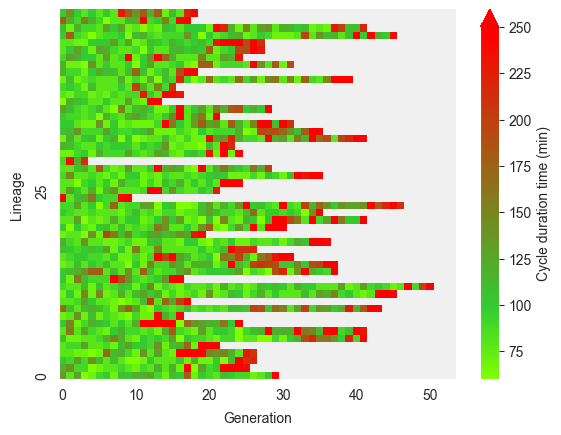

In [9]:
# Direct representation.
CYCLES = out[0]["cycle"]  # Extract cycles from the output.
IS_EXPERIMENTAL_DATA = False  # The data is simulated, not experimental.
FIG_DIR = None  # The figure is not saved.
pl.plot_lineages_cycles(CYCLES, IS_EXPERIMENTAL_DATA, FIG_DIR)

### 3.3. Lineage Sorting

Lineages in the set can be sorted by increasing:
- **`'lmin'`**: Initial length of the shortest telomere
- **`'lavg'`**: Initial average telomere length
- **`'gntai'`**: Generation of the onset of the `i`th sequence of non-terminal arrests
- **`'gsen'`**: Generation of senescence onset
- **`'gdeath'`**: Generation of death
- **`'len'`**: Length (equivalent to `'gdeath'` in simulations, but not in experimental data, which may include lineages still alive at the end of measurements).


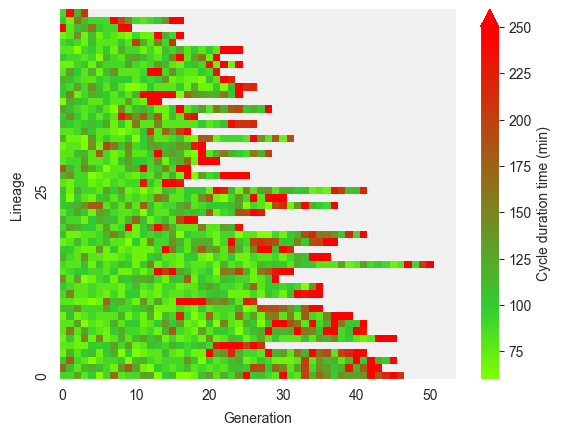

In [10]:
# Plot cycles after sorting lineages by the length of the shortest telomere at generation 0.
TYPE_OF_SORT = "lmin"

OUT_SORTED = sim.sort_lineages(out, TYPE_OF_SORT)  # Sort lineages.
CYCLES_SORTED = OUT_SORTED[0]["cycle"]  # Extract sorted cycles.
pl.plot_lineages_cycles(CYCLES_SORTED, IS_EXPERIMENTAL_DATA, FIG_DIR)  # Plot cycles.

In addition, add labels for lineage types.

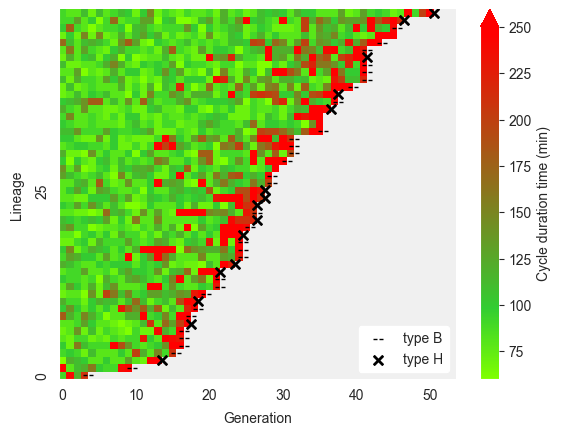

In [11]:
# Plot cycles after sorting lineages by their generation of death.
TYPE_OF_SORT = "gdeath"

OUT_SORTED = sim.sort_lineages(out, TYPE_OF_SORT)
CYCLES_SORTED = OUT_SORTED[0]["cycle"]
LINEAGE_TYPES_SORTED = OUT_SORTED[2]  # Extract also sorted lineage types.
pl.plot_lineages_cycles(
    CYCLES_SORTED, IS_EXPERIMENTAL_DATA, FIG_DIR, lineage_types=LINEAGE_TYPES_SORTED
)

Last example: order by increasing generation of the first non-terminal arrest.
Make sure to include only *type B* lineages!

New subsimulation.


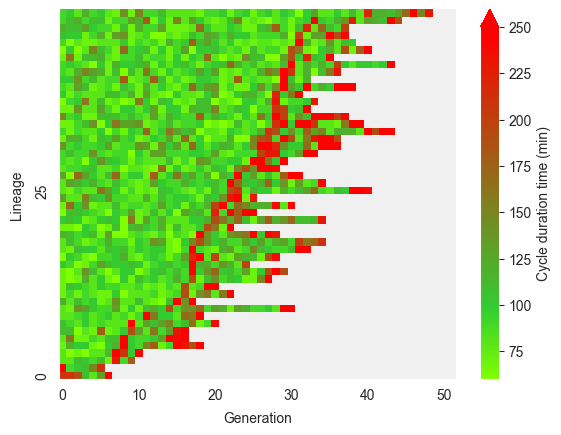

In [12]:
# New simulation required for new characteristics.
CHARACTERISTICS = ["btype"]
out = sim.simulate_lineages_evolution(
    LINEAGE_COUNT, CHARACTERISTICS, PARAMETERS, is_evo_returned=True
)

# Plot cycles after sorting lineages by the generation of the first non-terminal arrest.
TYPE_OF_SORT = "gnta1"
OUT_SORTED = sim.sort_lineages(out, TYPE_OF_SORT)
CYCLES_SORTED = OUT_SORTED[0]["cycle"]
pl.plot_lineages_cycles(CYCLES_SORTED, IS_EXPERIMENTAL_DATA, FIG_DIR)

If we check the lineage types in the ordered set, we see indeed that only *type B* lineages are present (i.e., each lineage is of type `1`, as specified in the one-lineage case output description).


In [13]:
LINEAGE_TYPES = OUT_SORTED[2]
print(LINEAGE_TYPES)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


### 3.4. Generations of arrest

Let us continue with the previous simulation but focus only on the generation at which a sequence of arrests was triggered. Following the output structure described in Section 2, this information is contained in:


In [14]:
GTRIGS = OUT_SORTED[1]  # Extract generations of arrests.
print(GTRIGS)

{'nta': array([[ 0., nan],
       [ 0., nan],
       [ 7., nan],
       [ 7., nan],
       [ 8., nan],
       [ 8., nan],
       [ 9., nan],
       [ 9., nan],
       [11., nan],
       [14., nan],
       [15., nan],
       [16., nan],
       [16., nan],
       [17., nan],
       [17., nan],
       [17., nan],
       [17., 20.],
       [17., nan],
       [18., 31.],
       [18., 25.],
       [19., nan],
       [20., nan],
       [20., 22.],
       [20., 28.],
       [22., nan],
       [22., nan],
       [22., nan],
       [23., nan],
       [24., nan],
       [25., nan],
       [26., nan],
       [26., nan],
       [26., 29.],
       [27., nan],
       [28., 31.],
       [28., nan],
       [28., nan],
       [28., nan],
       [28., nan],
       [29., 32.],
       [29., nan],
       [29., nan],
       [30., 36.],
       [30., 32.],
       [30., 37.],
       [31., nan],
       [31., nan],
       [32., nan],
       [33., 38.],
       [40., 46.]]), 'sen': array([ 6.,  5., nan, 10., 15., 1

Which can be represented as follows:

ValueError: x and y must have same first dimension, but have shapes (50,) and (20,)

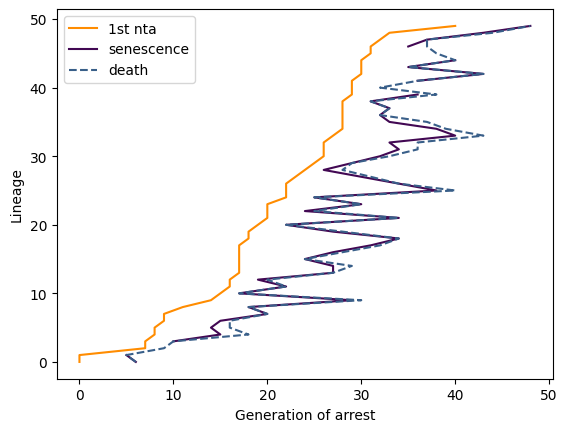

In [15]:
LINEAGES = np.arange(LINEAGE_COUNT)

# Generation of the first non-terminal arrest (nta).
plt.plot(GTRIGS["nta"][:, 0], LINEAGES, label="1st nta", color="darkorange")

# Generation of senescence onset.
plt.plot(GTRIGS["sen"], LINEAGES, label="senescence")

# Generation of death.
plt.plot(GTRIGS["death"], LINEAGES, "--", label="death")

plt.xlabel("Generation of arrest")
plt.ylabel("Lineage")
plt.legend()
plt.show()

To draw a "proper" curve of generations of senescence onset, one should rather:

- First, make sure that only senescent lineages are simulated. In the above simulation, some lineages may not be senescent, which would result in a discontinuous 'senescent' line.
- Second, order the lineages by increasing generation of senescence onset.

Note that computing cycle duration times is no longer necessary for this task, so `is_evo_returned` can be set to `False` (default value).



New subsimulation.


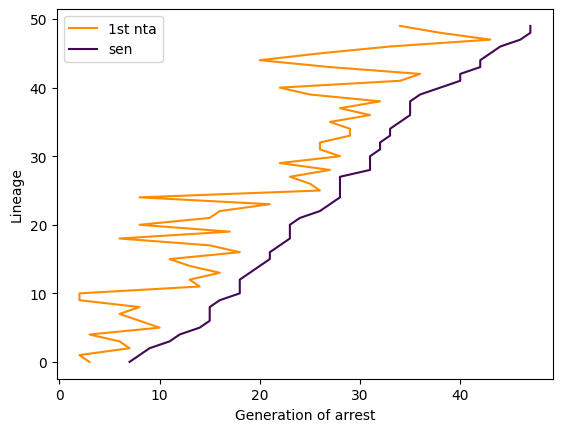

In [16]:
CHARACTERISTICS = [
    "btype",
    "senescent",
]  # Add 'senescent' to the list of characteristics.

# Simulation with new characteristics and `is_evo_returned` set to `False`.
# Remark. Explicitly setting `is_evo_returned=False` is not necessary, as it is `False` by default.
out = sim.simulate_lineages_evolution(LINEAGE_COUNT, CHARACTERISTICS, PARAMETERS)

TYPE_OF_SORT = "gsen"  # Order by increasing generation of senescence onset.
OUT_SORTED = sim.sort_lineages(out, TYPE_OF_SORT)
GTRIGS = OUT_SORTED[1]

# Generation of the first non-terminal arrest: not necessarily in increasing order anymore since sorted by 'gsen'.
plt.plot(GTRIGS["nta"][:, 0], LINEAGES, label="1st nta", color="darkorange")

# Generation of the senescence onset.
plt.plot(GTRIGS["sen"], LINEAGES, label="sen")

plt.xlabel("Generation of arrest")
plt.ylabel("Lineage")
plt.legend()
plt.show()

### 3.5. Histograms 

#### Length of sequences of arrests

To retrieve the length of the sequences of arrests, ensure that `is_lcycle_count_returned` is set to `True`.

New subsimulation.


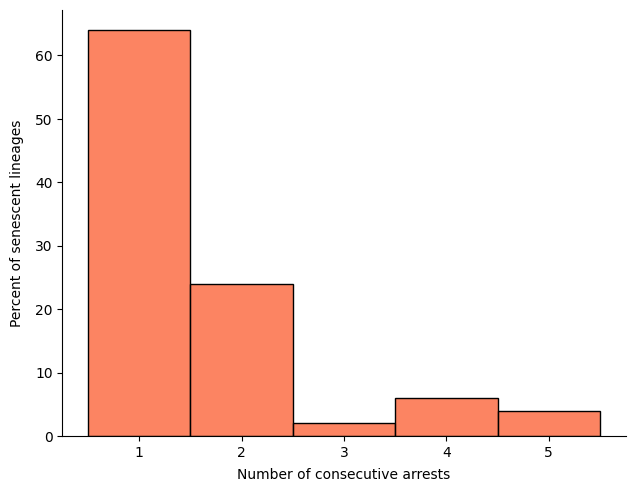

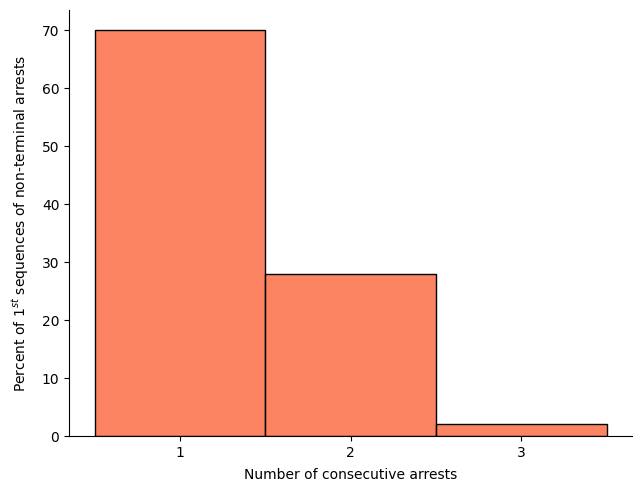

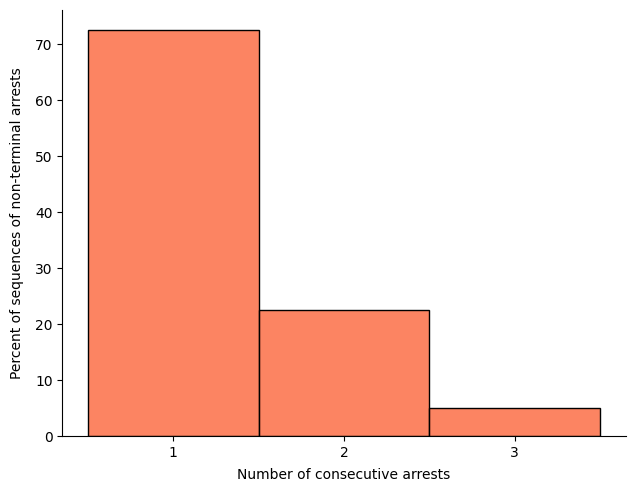

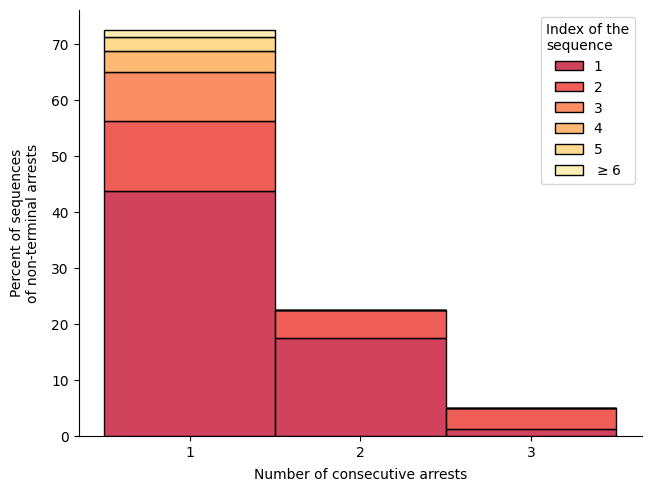

In [17]:
# Simulation with new characteristics and `is_lcycle_count_returned` set to `True`.
CHARACTERISTICS = ["btype", "senescent"]
out = sim.simulate_lineages_evolution(
    LINEAGE_COUNT, CHARACTERISTICS, PARAMETERS, is_lcycle_count_returned=True
)

ARREST_PER_SEQ_COUNT = out[5]  # Extract the number of arrests per sequence of arrests.

# Plot histogram of the number of senescent cycles.
ARREST_TYPE = "sen"  # Legit since 'senescent' belongs to the lineage characteristics.
pl.plot_histogram_from_lcycle_counts(ARREST_PER_SEQ_COUNT, ARREST_TYPE)
# Plot histogram of the number of arrests in the first sequence of non-terminal arrest.
ARREST_TYPE = "nta1"  # Legit since 'btype' ('arrested1' would have been valid too) is in the lineages characteristics.
pl.plot_histogram_from_lcycle_counts(ARREST_PER_SEQ_COUNT, ARREST_TYPE)
# Plot histogram of the number of arrest in sequences of non-terminal arrests (all confounded).
ARREST_TYPE = "nta"
pl.plot_histogram_from_lcycle_counts(ARREST_PER_SEQ_COUNT, ARREST_TYPE)
# Plot histogram of the number of arrest in each sequence of non-terminal arrests.
ARREST_TYPE = "nta_by_idx"
pl.plot_histogram_from_lcycle_counts(ARREST_PER_SEQ_COUNT, ARREST_TYPE);

New subsimulation.


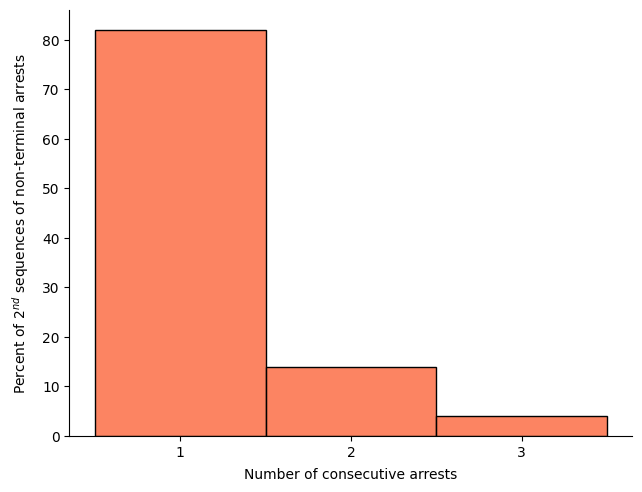

In [18]:
# Plot the histogram of the number of arrest in the 2nd sequence of non-terrminal arrests.

# Remark. It may be preferable to ask for lineages exhibiting at least two sequences of non-terminal-arrests (nta).
CHARACTERISTICS = ["arrested2"]
out = sim.simulate_lineages_evolution(
    LINEAGE_COUNT, CHARACTERISTICS, PARAMETERS, is_lcycle_count_returned=True
)

ARREST_PER_SEQ_COUNT = out[5]  # Extract the number of arrests per sequence of arrests.
ARREST_TYPE = "nta2"  # Plot the histogram for the second sequence of nta.
pl.plot_histogram_from_lcycle_counts(ARREST_PER_SEQ_COUNT, ARREST_TYPE);

#### Length of telomeres triggering an arrest

See Section 4 for already implemented functions.
Otherwise, the data can be retrieved using:

In [19]:
# Simulation with `is_evo_returned` set to `True` to track the evolution of `lmin`.
CHARACTERISTICS = ["senescent"]
out = sim.simulate_lineages_evolution(
    LINEAGE_COUNT, CHARACTERISTICS, PARAMETERS, is_evo_returned=True
)

EVO_LMIN = out[0][
    "lmin"
]  # Extract the shortest telomere length in cells across lineages and generations.
G_SEN = out[
    1
][
    "sen"
].astype(
    int
)  # Extract the generations of senescence onset for all lineages (converted to integer type).

# Print the length of the shortest telomere at senescence onset for each lineage.
print([EVO_LMIN[i, G_SEN[i]] for i in range(LINEAGE_COUNT)])

New subsimulation.
[np.float64(75.0), np.float64(-11.0), np.float64(40.0), np.float64(-2.0), np.float64(95.0), np.float64(90.0), np.float64(31.0), np.float64(99.0), np.float64(50.0), np.float64(15.0), np.float64(-9.0), np.float64(93.0), np.float64(35.0), np.float64(126.0), np.float64(18.0), np.float64(-5.0), np.float64(24.0), np.float64(10.0), np.float64(31.0), np.float64(21.0), np.float64(31.0), np.float64(93.0), np.float64(15.0), np.float64(135.0), np.float64(106.0), np.float64(41.0), np.float64(53.0), np.float64(68.0), np.float64(26.0), np.float64(-8.0), np.float64(19.0), np.float64(84.0), np.float64(42.0), np.float64(119.0), np.float64(109.0), np.float64(152.0), np.float64(-16.0), np.float64(60.0), np.float64(55.0), np.float64(28.0), np.float64(115.0), np.float64(136.0), np.float64(86.0), np.float64(38.0), np.float64(33.0), np.float64(40.0), np.float64(51.0), np.float64(88.0), np.float64(52.0), np.float64(49.0)]


## 4. Several sets of lineages: statistics on simulations

The next step consists in simulating `SIMULATION_COUNT` sets of `LINEAGE_COUNT` lineages, allowing for the calculation of average or extreme values across all simulations. This approach is meaningful only if all sets have been ordered consistently, so specifying the type of sorting is crucial.

The total `SIMULATION_COUNT` simulations can be sped up by running them in parallel, which can typically be achieved by specifying a number of processors (`PROC_COUNT`) greater than one.

### 4.1. Model parameter updates

While model parameters needed to be passed to the previous `sim.simulate*` functions, only possible updates of the default parameters (`PARAMETERS = par.PAR_DEFAULT_LIN`) are passed to most of the functions (actually based on these previous functions) in the code through the `par_update` argument. The reason, again, is that default parameters are generally not intended to be changed.

By default, `par_update` is `None`, meaning that the model parameters remain exactly as the default ones.
When updates are needed, `par_update` should be a dictionary containing the keys from `par.PAR_DEFAULT_LIN` that need to be updated, along with their corresponding updated values.

> **Example 1: Update of $p_{accident}$ only.** Although a bit laborious, one must update the `'p_exit'` key of the model parameters (see Section 1), which is a dictionary, by initializing it with a new dictionary where only the `'accident'` key has been modified:

In [20]:
# Definition of `par_update` corresponding to an update of `p_accident`.
P_ACC_NEW = 5  # New value for p_accident.

P_EXIT_DEFAULT = par.PAR_DEFAULT_LIN[
    "p_exit"
]  # Default 'p_exit' key of default model parameters.
P_EXIT_NEW = deepcopy(P_EXIT_DEFAULT)
P_EXIT_NEW["accident"] = P_ACC_NEW

PAR_UPDATE = {"p_exit": P_EXIT_NEW}

> **Example 2. Update of parameter $\ell_{minA}.$** Through the `'fit'`key.

In [21]:
# Definition of `par_update` corresponding to an update of `lmin_A`.
LMIN_A_NEW = 40  # New value.

FIT_NEW = deepcopy(
    par.PAR_DEFAULT_LIN["fit"]
)  # Default 'fit' key of default model parameters.
FIT_NEW[1][0][2] = LMIN_A_NEW
PAR_UPDATE = {"fit": FIT_NEW}

> **Example 3. Both previous updates.**

In [22]:
PAR_UPDATE = {"p_exit": P_EXIT_NEW, "fit": FIT_NEW}

### 4.2. Simulation parameters

Default values for simulation parameters are given by `telomeres.model.parameters.PAR_DEFAULT_SIM_LIN`.

In [23]:
PARMATERS_SIMU = deepcopy(par.PAR_DEFAULT_SIM_LIN)
print(PARMATERS_SIMU)

{'postreat_dt': None, 'hist_lmins_axis': None, 'is_lcycle_count_saved': False, 'is_evo_saved': False}


The first two parameters can be left to default (`None`):
- `PARMATERS_SIMU['postreat_dt']`: Omitted for this demo, as it is not used in the simulations of in the article
- `PARMATERS_SIMU['hist_lmins_axis']`: Relevant only to compute histograms for telomere lengths triggering an arrest, in which case it corresponds to the x-axis of the histogram

The remaining parameters can be adjusted based on specific needs but are best left unchanged if possible. 
Indeed, default values speed up calculations and yield lighter outputs:
- `PARMATERS_SIMU['is_lcycle_count_saved']`: Set to `True` if the length of sequences of arrest (i.e., number of consecutive long cycles),  is to be returned, in particular to draw histograms of arrest sequence lengths; `False` otherwise.
- `PARMATERS_SIMU['is_evo_saved']`: Equivalent to  `is_evo_returned` mentioned above. Set to `True` if data along generations (cycle duration times and telomere lengths) is required; False otherwise.

These parameters can be updated using the `par_sim_update` argument, similar to how model parameters are updated with `par_update`.


### 4.3. Simulation

One can use `sim.simulate_n_average_lineages` directly.

In [24]:
# Example of statistics on 6 sets of 20 lineages, with specific characteristics and ordered in one or several distinct ways.
LINEAGE_COUNT = 20
SIMULATION_COUNT = 6  # Number of simulation to average.
TYPES_OF_SORT = [
    "gnta1",
    "gsen",
]  # 2 types of ordering, resulting in 2 average outputs (but 6 simulations only, instead of 2 x 6).
PROC_COUNT = 2  # Adjust based on your computer's capacity.
CHARACTERISTICS = ["btype", "senescent"]

# Simulate and average sets of lineages with the specified parameters.
out = sim.simulate_n_average_lineages(
    LINEAGE_COUNT,
    SIMULATION_COUNT,
    TYPES_OF_SORT,
    CHARACTERISTICS,
    par_update=None,
    par_sim_update=None,
    proc_count=PROC_COUNT,
)

The output, `out`, is structured such that `out[k]` has a format similar to the first two elements returned by `sim.simulate_lineages_evolution`, where `k` corresponds to each type of sorting in `TYPES_OF_SORT`.

In [25]:
print(out)

{'gnta1': (None, {'nta': {'mean': array([[ 3.5       , 13.        ,         nan,         nan],
       [ 5.33333333,  7.        ,         nan,         nan],
       [ 7.66666667, 23.        ,         nan,         nan],
       [10.5       , 16.        , 23.        , 28.        ],
       [12.66666667, 25.33333333, 30.        , 36.        ],
       [13.66666667, 20.5       , 24.        ,         nan],
       [16.16666667, 30.        , 36.        ,         nan],
       [17.33333333, 25.        ,         nan,         nan],
       [18.16666667, 30.        ,         nan,         nan],
       [19.5       , 24.5       ,         nan,         nan],
       [21.        , 25.        , 28.5       , 36.        ],
       [22.66666667, 28.66666667, 33.5       , 36.        ],
       [24.        ,         nan,         nan,         nan],
       [25.66666667, 28.66666667, 33.        , 35.        ],
       [27.33333333, 34.        ,         nan,         nan],
       [29.        , 37.5       ,         nan,     

### 4.4. Plot

#### Generations of arrest

In particular, if one wishes to retrieve statistics on the curve of generations of senescence obtained after sorting by `'gsen'`, they will focus on:

{'mean': array([ 9.83333333, 13.5       , 16.5       , 19.66666667, 22.83333333,
       24.5       , 25.66666667, 27.66666667, 28.66666667, 29.66666667,
       30.33333333, 31.16666667, 32.33333333, 33.83333333, 35.33333333,
       38.5       , 39.66666667, 41.5       , 44.66666667, 47.        ]), 'perup': array([15.5  , 17.75 , 19.   , 21.   , 26.75 , 27.75 , 28.   , 29.75 ,
       31.75 , 31.875, 32.875, 33.   , 33.875, 35.   , 37.875, 40.875,
       42.75 , 44.875, 46.875, 53.25 ]), 'perdown': array([ 4.25 , 10.125, 13.25 , 16.25 , 18.375, 21.25 , 23.125, 26.125,
       26.125, 27.25 , 27.25 , 29.125, 31.125, 32.125, 33.125, 35.25 ,
       36.125, 39.   , 41.25 , 44.125])}


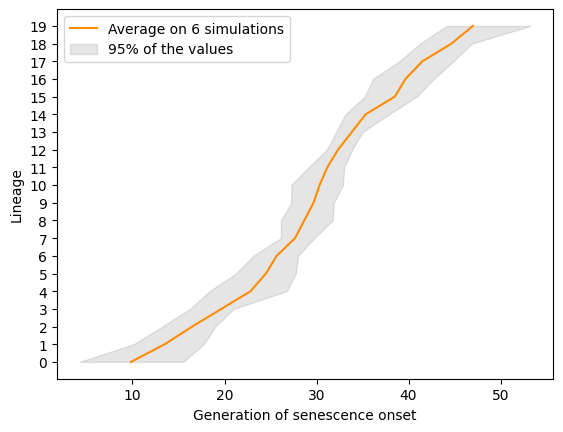

In [26]:
# Statistics on graphs of senescence onset.
GSEN_STAT = out["gsen"][1]["sen"]
print(GSEN_STAT)

LINEAGES = np.arange(LINEAGE_COUNT).astype(int)
plt.plot(
    GSEN_STAT["mean"],
    LINEAGES,
    label=f"Average on {SIMULATION_COUNT} simulations",
    color="darkorange",
)
plt.fill_betweenx(
    LINEAGES,
    GSEN_STAT["perdown"],
    GSEN_STAT["perup"],
    label=f"{fp.PERCENT}% of the values",
    color="gray",
    alpha=0.2,
)
plt.yticks(LINEAGES)
plt.xlabel("Generation of senescence onset")
plt.ylabel("Lineage")
plt.legend()
plt.show()

"All-in-one" functions can compute and plot such generation curves alongside the experimental graphs:

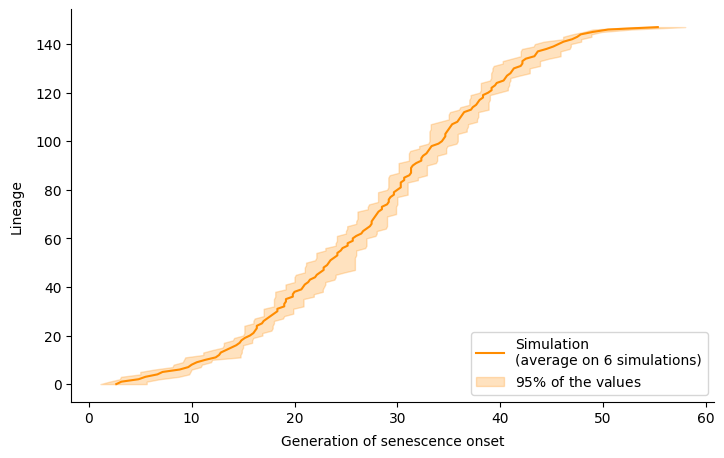

In [27]:
# Compute and plot one graph.
SIMULATION_COUNT = 6
DATA_EXP = extract_postreat_lineages()  # Extract experimental data (used to define `LINEAGE_COUNT` as equal to the experimental one).
FIG_DIR = None  # Figure not saved.

CHARACTERISTICS = ["senescent"]
pl.compute_n_plot_gcurve(
    DATA_EXP, SIMULATION_COUNT, CHARACTERISTICS, FIG_DIR, par_update=None
)

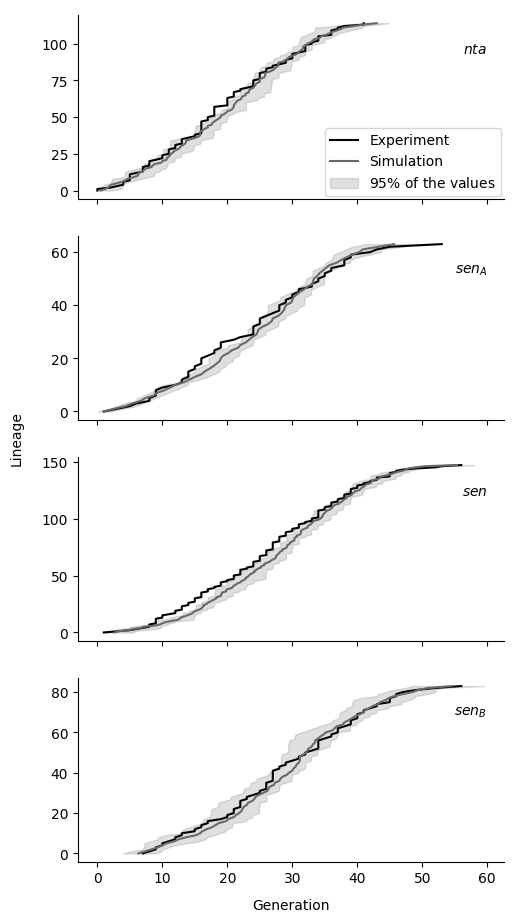

In [28]:
# Compute and plot different graphs in one, corresponding to different values of `CHARACTERISTICS`.
# Specify a list of sets of characteristics (not one anymore), the classical ones being:
CHARACTERISTICS_S = [
    ["btype"],
    ["atype", "senescent"],
    ["senescent"],
    ["btype", "senescent"],
]
# ... respectively yielding the curves of 1st nta, senescence onset of only type A, all types or only type B, labeled as:
LABELS = [r"$nta$", r"$sen_A$", r"$sen$", r"$sen_B$"]

pl.compute_n_plot_gcurves_wrt_charac(
    DATA_EXP,
    SIMULATION_COUNT,
    CHARACTERISTICS_S,
    FIG_DIR,
    par_update=None,
    labels=LABELS,
)

#### Cycle  duration times

One might also be interested in cycle duration times but should not forget to update `PARAMETERS_SIMU['is_evo_saved']` accordingly.

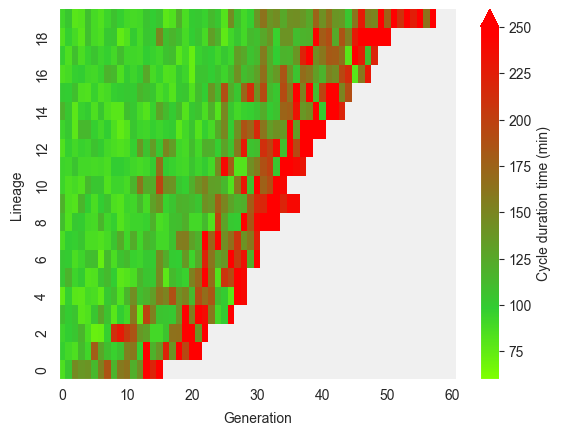

In [29]:
# Cycle duration times from `simulate_n_average_lineages`.
CHARACTERISTICS = ["senescent"]
TYPES_OF_SORT = ["gsen"]
PAR_SIM_UPDATE = {"is_evo_saved": True}

out = sim.simulate_n_average_lineages(
    LINEAGE_COUNT,
    SIMULATION_COUNT,
    TYPES_OF_SORT,
    CHARACTERISTICS,
    par_sim_update=PAR_SIM_UPDATE,
    proc_count=PROC_COUNT,
)  # Simulate.
CYCLES_STAT = out["gsen"][0]["cycle"]  # Extract average simulated cycle durations.

pl.plot_lineages_cycles(
    CYCLES_STAT, IS_EXPERIMENTAL_DATA, FIG_DIR
)  # Plot the average as if it was the output of one simulation.

#### Histograms

Similarly, data can be extracted from the output of `sim.simulate_n_average_lineages`, run with `par_sim_update = {'is_lcycle_count_saved': True, 'is_evo_saved': True}`, or use the following "all-in-one" functions:

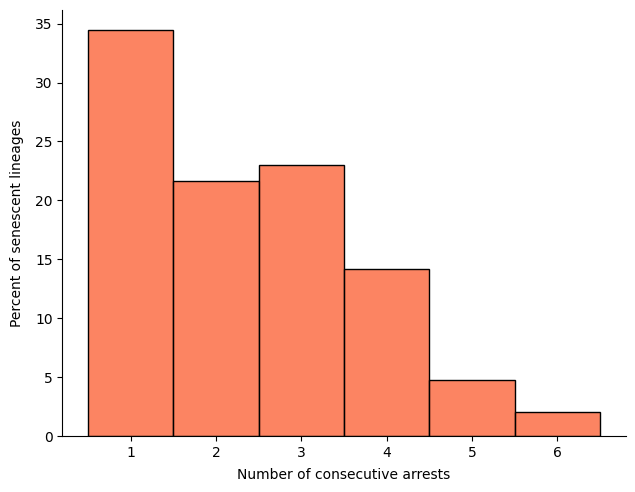

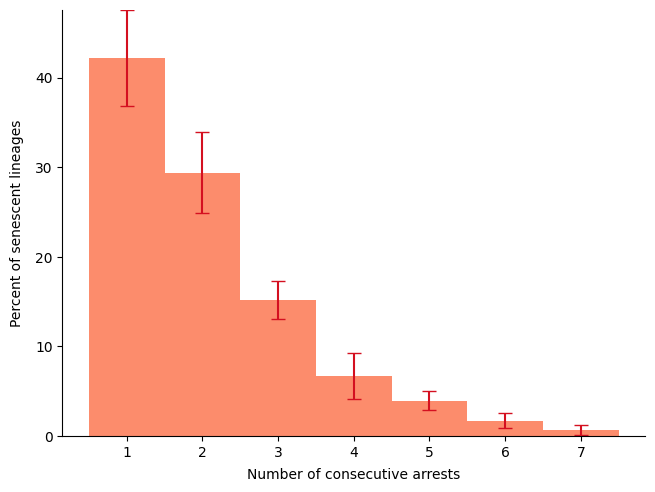

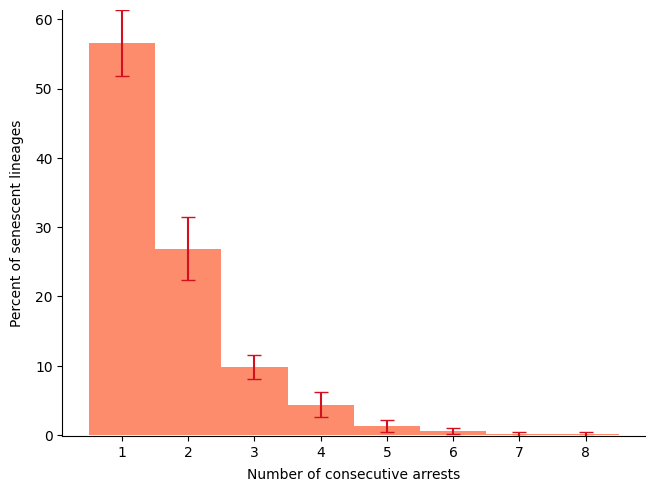

prop > 27 bp:  0.7948887627843324 1.0 



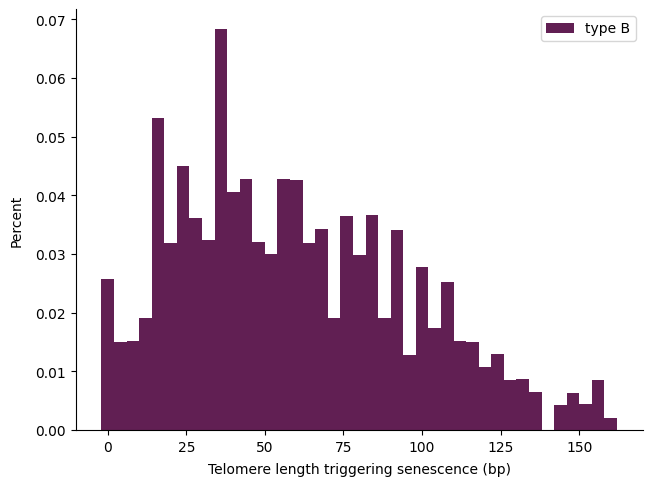

prop > 27 bp:  0.010416666666666666 1.0 



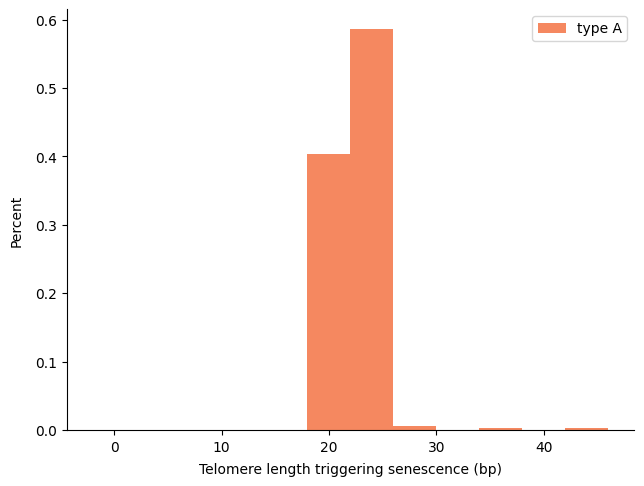

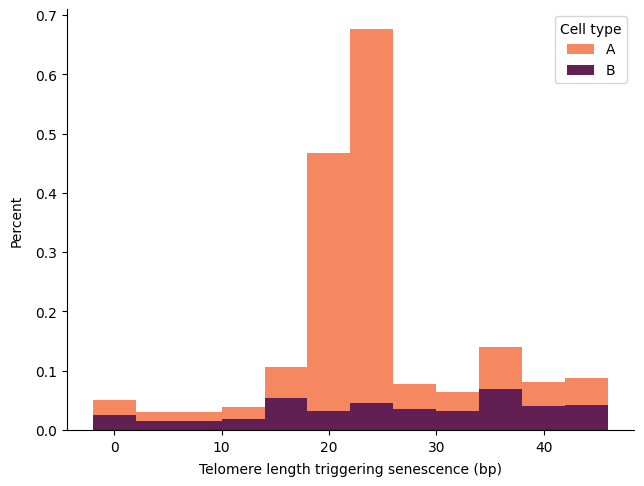

prop > 27 bp:  0.7148749035454195 0.9999999999999999 



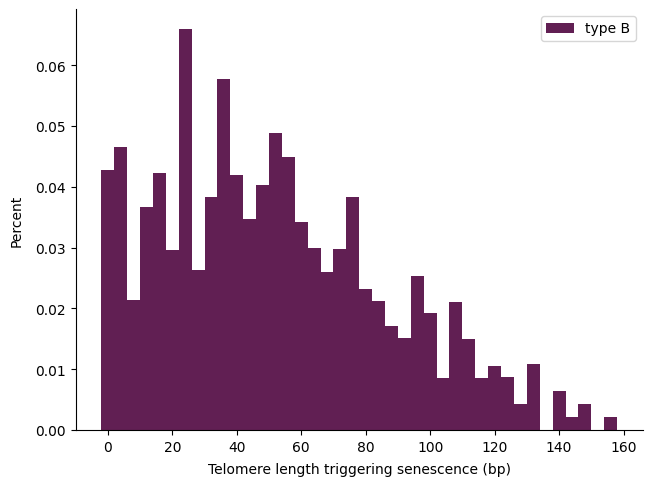

prop > 27 bp:  0.6822916666666665 0.9973958333333333 



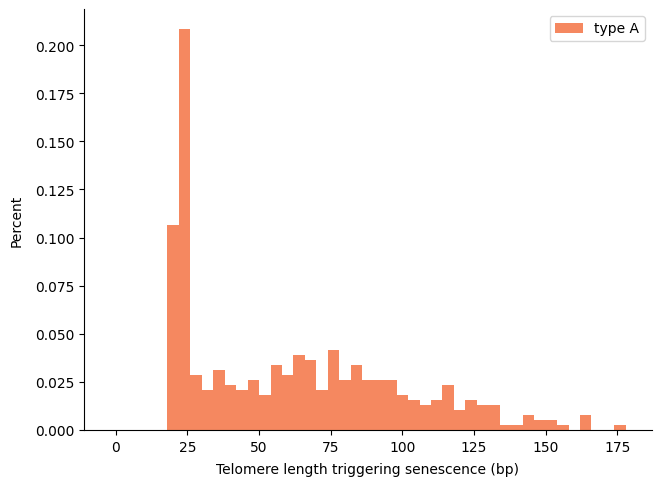

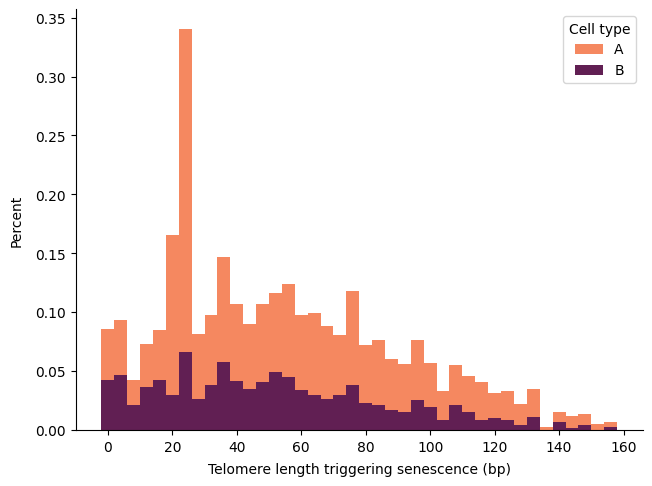

In [30]:
# Number of senescent cycles.
LCYCLE_TYPES = ["sen"]
CHARACTERISTICS = ["senescent"]
pl.compute_n_plot_lcycle_hist(
    DATA_EXP, SIMULATION_COUNT, CHARACTERISTICS, LCYCLE_TYPES, FIG_DIR
)

# Lmin triggering senescence.
CHARACTERISTICS_S = [["btype", "senescent"], ["atype", "senescent"]]
# > Ground truth of the model.
pl.compute_n_plot_hist_lmin(
    DATA_EXP,
    SIMULATION_COUNT,
    CHARACTERISTICS_S,
    par.X_AXIS_HIST_LMIN,
    FIG_DIR,
    width=4,
    is_htype_seen=True,
)
# > As it would have been perceived experimentally.
# Remark. Senescence of type B lineages appears longer than it really is since the non-terminal arrests directly preceding senescence acount as senescent cycles.
pl.compute_n_plot_hist_lmin(
    DATA_EXP,
    SIMULATION_COUNT,
    CHARACTERISTICS_S,
    par.X_AXIS_HIST_LMIN,
    FIG_DIR,
    width=4,
    is_htype_seen=False,
)

#### Sensitivity analysis

To test the sensitivity to a certain parameter of the model, use `plot_gcurves_wrt_par`;  or `plot_gcurves_wrt_par_n_char` to plot different graphs in one, corresponding to different values of `CHARACTERISTICS`.

> **Example. Sensitivity to $p_{accident}$.**

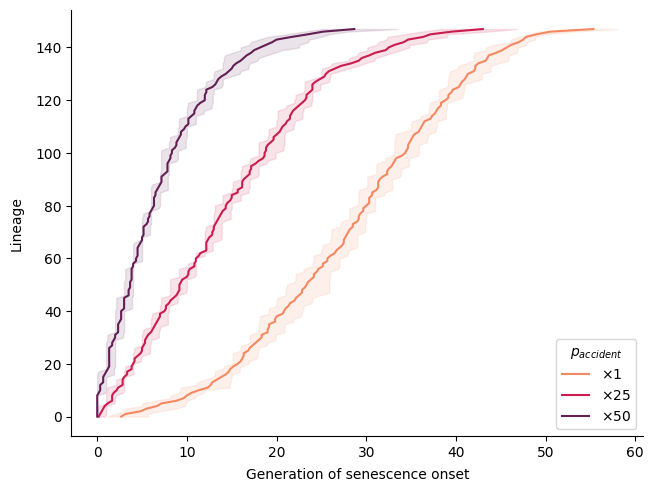

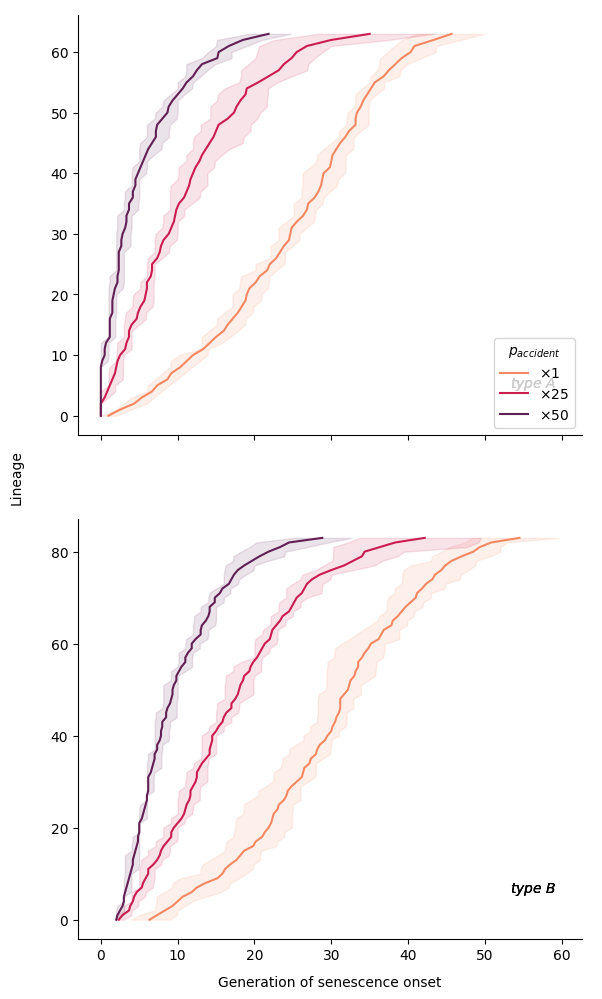

In [31]:
# Definition of the various new values for `p_accident`.
P_ACC_S = par.P_ACCIDENT * np.array([1.0, 25, 50.0])
VARYING_KEY = "accident"  # The key 'accident of the dictionary of parameters is the one to be varied.

P_EXIT_TMP = deepcopy(par.P_EXIT)
PAR_UPDATES = []  # List of `par_update` to use for simulation.
curve_labels = []
for p_acc in P_ACC_S:
    P_EXIT_TMP[VARYING_KEY] = p_acc
    PAR_UPDATES.append({"p_exit": deepcopy(P_EXIT_TMP)})
    curve_labels.append(r"$\times$" + str(int(p_acc / P_ACC_S[0])))

# Compute and plot average generations of senescence onset w.r.t `p_accident`.
CHARACTERISTICS = ["senescent"]
pl.plot_gcurves_wrt_par(
    DATA_EXP,
    SIMULATION_COUNT,
    CHARACTERISTICS,
    PAR_UPDATES,
    VARYING_KEY,
    FIG_DIR,
    curve_labels=curve_labels,
)

# Compute and plot average generations of senescence onset w.r.t to the cell type (A and B) and `p_accident`.
CHARACTERISTICS_S = [["atype", "senescent"], ["btype", "senescent"]]
TEXTS = [r"$\mathit{type~A}$", r"$\mathit{type~B}$"]
pl.plot_gcurves_wrt_par_n_char(
    DATA_EXP,
    SIMULATION_COUNT,
    CHARACTERISTICS_S,
    PAR_UPDATES,
    VARYING_KEY,
    FIG_DIR,
    texts=TEXTS,
    curve_labels=curve_labels,
)